# Capstone Project: Benchmarks
## Machine Learning Engineer Nanodegree
### Manceñido Agustín, 2019

<img src="img/bkgr_benchmark.jpg" alt="Backgroud" style="width: 100%; height: 400px;"/>

**Benchmarking** is the process of comparing the result to an existing method or running a very simple machine learning model to get baseline in performance. A baseline in performance gives an idea of how well all other models will actually perform on the problem.

For this project, two benchmark models were selected. First a [Persistence model](https://machinelearningmastery.com/persistence-time-series-forecasting-with-python/) will be used as a really simple and fast benchmark model. Then, a second and more advance [Xgboost model](https://xgboost.readthedocs.io/en/latest/) will be used to get a better idea of the performance using all the features available.

>**Notes:** 
* For the complete final model and results, please refer to the [Capstone exploration](https://machinelearningmastery.com/persistence-time-series-forecasting-with-python/) file.
* For the complete analysis of the dataset and the feature engineering that is used in this document, please refer to the [Capstone exploration](https://machinelearningmastery.com/persistence-time-series-forecasting-with-python/) file.

### Contents

* [Step 0](#step0): Import libraries & Load dataset
* [Step 1](#step1): Benchmark I - Persistence model
* [Step 2](#step2): Feature Engineering
* [Step 3](#step3): Split data
* [Step 4](#step4): Benchmark II - Xgboost model
* [Step 5](#step5): Results

---
<a id='step0'></a>
## Step 0: Import libraries & Load dataset

In [1]:
### Import libraries

## General
import pandas as pd
import numpy as np
from time import time

## Scikit-learn
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import mean_squared_log_error
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import TruncatedSVD

## Natural Language Toolkit
import nltk
from nltk.corpus import stopwords
nltk.download('stopwords')

## Benchmark II - Xgboost model
import xgboost as xgb

## Plot
from matplotlib import pyplot as plt

[nltk_data] Downloading package stopwords to
[nltk_data]     /home/nitsuga/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [2]:
# Load dataset
try:
    data = pd.read_csv("database.csv")
    data.drop(['meliid'], axis = 1, inplace = True)
    print("Dataset has {} samples with {} features each.".format(*data.shape))
except:
    print("Dataset could not be loaded. Is the dataset missing?")

display(data.head(n = 3))

Dataset has 795295 samples with 8 features each.


,title,sellerid,state,city,pos,sqty,price,created_at
0,Oximetro De Pulso Saturometro Digital Con Curv...,99179853,Capital Federal,CABA,NaN,1,799.99,2017-03-17 16:07:13
1,Oximetro De Pulso Saturometro Digital,127566027,Buenos Aires,Villa Bosch,NaN,1,600.00,2017-03-17 16:07:13
2,Oximetro De Pulso Saturometro Digital Con Curv...,99179853,Capital Federal,CABA,NaN,1,799.99,2017-03-17 16:52:10


---
<a id='step1'></a>
## Step 1: Benchmark I - Persistence model

The most common baseline method for supervised machine learning is the Zero Rule algorithm. This algorithm predicts the majority class in the case of classification, or the average outcome in the case of regression. This could be used for time series, but does not respect the serial correlation structure in time series datasets.

The equivalent technique for use with time series dataset is the **persistence algorithm**. The persistence algorithm uses the value at the previous time step (t-1) to predict the expected outcome at the next time step (t+1).

In [3]:
# Benchmark I dataset
bench_1_data = data.copy()
bench_1_data.drop(['title','sellerid','state','city','pos','sqty'], axis = 1, inplace = True)
bench_1_data.sort_values(by='created_at')
display(bench_1_data.head(n = 3))

,price,created_at
0,799.99,2017-03-17 16:07:13
1,600.00,2017-03-17 16:07:13
2,799.99,2017-03-17 16:52:10


In [4]:
# Create lagged dataset
values = pd.DataFrame(bench_1_data.price.values)
bench_1_data = pd.concat([values.shift(1), values], axis=1)
bench_1_data.columns = ['t-1', 't+1']
print(bench_1_data.head(5))

del values

      t-1     t+1
0     NaN  799.99
1  799.99  600.00
2  600.00  799.99
3  799.99  549.00
4  549.00  599.00


In [5]:
# split into train and test sets
X = bench_1_data.values
train_size = int(len(X) * 0.66)
train, test = X[1:train_size], X[train_size:]
X_train, y_train = train[:,0], train[:,1]
X_test, y_test = test[:,0], test[:,1]

del bench_1_data, X, train_size, train, test

In [6]:
# persistence model
def model_persistence(x):
    return x

In [7]:
# walk-forward validation
preds = list()
for x in X_test:
    pred = model_persistence(x)
    preds.append(pred)

In [8]:
# Test score: Benchmark I - Persistence model
test_score = mean_squared_log_error(y_test, preds)
print('Benchmark I - Persistence Model')
print('Test MSLE: %.3f' % test_score)

Benchmark I - Persistence Model
Test MSLE: 2.220


---
<a id='step2'></a>
## Step 2: Feature Engineering

**Feature engineering** is the process of using domain knowledge of the data to create features that make machine learning algorithms work.This process increases the predictive power of machine learning algorithms by creating features from raw data that help facilitate the machine learning process.

Using the results from the **dataset exploration** the features will be modify in a similar way than the final model in order to test the Xgboost model with similar information.

In [9]:
# date time features
data['created_at'] = pd.to_datetime(data['created_at'])
data['weekday'] = data.created_at.dt.weekday
data['week'] = data.created_at.dt.week 
data['hour'] = data.created_at.dt.hour 

# title word length
data['title'] = data['title'].fillna(" ")
data['title_len'] = data['title'].apply(lambda x : len(x.split()))

# state/city
data['state_city'] = data.state +" / "+ data.city

In [10]:
# LabelEncoder for state_city feature
le = LabelEncoder()
le.fit(data.state_city)
data['state_city'] = le.transform(data.state_city)
del le

In [11]:
# Frequency-inverse document frequency (TF-IDF) Vectorizer for title feature
tfidf_vec = TfidfVectorizer(ngram_range=(1,2), stop_words=set(stopwords.words('spanish')))
data_tfidf = tfidf_vec.fit_transform(data['title'].values.tolist())
n_comp = 10

svd_obj = TruncatedSVD(n_components=n_comp, algorithm='arpack')
svd_obj.fit(data_tfidf.asfptype())

data_svd = pd.DataFrame(svd_obj.transform(data_tfidf.asfptype()))
data_svd.columns = ['svd_title_tfidf_'+str(i) for i in range(n_comp)]
data = pd.concat([data, data_svd], axis=1)

del tfidf_vec, data_tfidf, n_comp, svd_obj, data_svd

In [12]:
# drop available data, irrelevant or highly correlated features
# ['sellerid','title','state','city','created_at']
dropable = ['sellerid','title','state','city','created_at']
not_available = ['pos']
data.drop(not_available+dropable, axis = 1, inplace = True)
del dropable, not_available

In [13]:
# Log target feature
data.price = np.log(data.price.values)

---
<a id='step3'></a>
## Step 3: Split data

In [14]:
# split data
target = data['price']
features = data.drop('price', axis = 1)
f_train, X_test, t_train, y_test = train_test_split(features, target, random_state=1)
X_train, X_valid, y_train, y_valid = train_test_split(f_train, t_train, test_size=0.2, random_state=1987)

In [15]:
display(X_train.head(n = 3))

,sqty,weekday,week,hour,title_len,state_city,svd_title_tfidf_0,svd_title_tfidf_1,svd_title_tfidf_2,svd_title_tfidf_3,svd_title_tfidf_4,svd_title_tfidf_5,svd_title_tfidf_6,svd_title_tfidf_7,svd_title_tfidf_8,svd_title_tfidf_9
724175,1,4,10,19,12,1553,0.107443,-0.109448,-0.009225,-0.007943,0.056319,-0.043693,-0.037359,0.056473,-0.014742,0.008583
342614,1,0,37,17,11,1361,0.264651,-0.280809,-0.016945,-0.007794,-0.141684,-0.048031,-0.012951,-0.004371,-0.079468,0.035270
523561,1,2,49,21,7,1361,0.000416,-0.000353,0.000583,0.000029,0.000464,-0.000879,0.010671,0.001175,0.001405,0.018801


---
<a id='step4'></a>
## Step 4: Benchmark II - Xgboost model

In [16]:
# Prepare date for Xgboost
data_train = xgb.DMatrix(X_train, label=y_train)
data_valid = xgb.DMatrix(X_valid, label=y_valid)
data_test = xgb.DMatrix(X_test)
# Create Xgboost model
watchlist = [(data_train, 'train'), (data_valid, 'valid')]
xgb_par = {'min_child_weight': 20, 'eta': 0.05, 'colsample_bytree': 0.5, 'max_depth': 15,
            'subsample': 0.9, 'lambda': 2.0, 'nthread': -1, 'booster' : 'gbtree', 'silent': 1,
            'eval_metric': 'rmse', 'objective': 'reg:linear'}

model = xgb.train(xgb_par, data_train, 80, watchlist, early_stopping_rounds=20, maximize=False, verbose_eval=20)

print('Modeling RMSLE %.5f' % model.best_score)

[0]	train-rmse:6.17139	valid-rmse:6.16884
Multiple eval metrics have been passed: 'valid-rmse' will be used for early stopping.

Will train until valid-rmse hasn't improved in 20 rounds.
[20]	train-rmse:2.31102	valid-rmse:2.31378
[40]	train-rmse:0.97858	valid-rmse:0.994688
[60]	train-rmse:0.565433	valid-rmse:0.602063
[79]	train-rmse:0.449838	valid-rmse:0.502407
Modeling RMSLE 0.50241


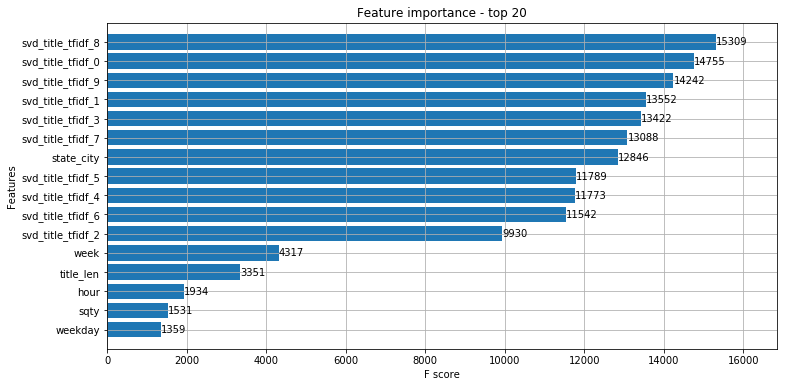

In [17]:
# Plot the important variables
fig, ax = plt.subplots(figsize=(12,6))
xgb.plot_importance(model, max_num_features=20, height=0.8, ax=ax)
plt.title("Feature importance - top 20")

plt.show()

In [18]:
# Shape normalizaition: y_test, preds
preds = model.predict(data_test)
preds = np.asarray(preds, dtype=np.float32)
y_test = np.asarray(y_test, dtype=np.float32)
y_test = y_test.reshape(preds.shape)

In [19]:
# Convert back to real values
y_test = np.exp(y_test)
preds = np.exp(preds)

In [20]:
# Add results to table and display
results = X_test.copy()
results['y_test'] = y_test
results['preds'] = preds

display(results.head())

,sqty,weekday,week,hour,title_len,state_city,svd_title_tfidf_0,svd_title_tfidf_1,svd_title_tfidf_2,svd_title_tfidf_3,svd_title_tfidf_4,svd_title_tfidf_5,svd_title_tfidf_6,svd_title_tfidf_7,svd_title_tfidf_8,svd_title_tfidf_9,y_test,preds
468969,1,4,45,10,8,1258,0.000073,-0.000026,0.000022,0.000023,-0.000048,-0.000010,0.000452,0.000125,0.000138,0.001132,334.999908,339.996765
28715,0,6,14,3,6,1720,0.004843,-0.001155,0.011469,-0.003371,0.013947,-0.006617,0.040843,-0.005716,0.012165,0.075770,2805.000244,2600.343994
544345,1,3,50,18,9,1290,0.027844,-0.011430,-0.000379,-0.000797,-0.019390,0.000282,0.018368,0.012092,0.024066,-0.011043,2499.000244,2116.227051
83520,1,1,19,7,8,1589,0.151660,-0.135138,-0.010820,-0.015625,0.466398,-0.289221,0.054791,-0.195767,0.207799,-0.033576,2189.999512,2179.371582
589387,1,3,1,11,9,1385,0.001737,0.000543,0.000579,0.000391,-0.000611,-0.001549,0.013553,0.001780,0.005564,0.023764,4999.001953,1949.519775


In [21]:
# Test score: Benchmark II - Xgboost model
test_score = mean_squared_log_error(y_test, preds)
print('Benchmark II - Xgboost model')
print('Test MSLE: %.3f' % test_score)

Benchmark II - Xgboost model
Test MSLE: 0.244


---
<a id='step5'></a>
## Step 5: Results

The test score for the selected benchmarks were:

* Benchmark I - **Persistence Model** = 2.220
* Benchmark II - **Xgboost model** = 0.244

The score used for the comparison was **Mean squared logarithmic error**. This function computes a risk metric corresponding to the expected value of the squared logarithmic (quadratic) error or loss and returns a non-negative floating point value (**the best value is 0.0**)